In [27]:
import pypsa 
import numpy as np
from pypsa.linopt import get_var, linexpr, join_exprs, define_constraints, get_dual, get_con, write_objective, get_sol, define_variables
from pypsa.descriptors import nominal_attrs
from pypsa.linopf import lookup, network_lopf, ilopf
from pypsa.pf import get_switchable_as_dense as get_as_dense
from pypsa.descriptors import get_extendable_i, get_non_extendable_i
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import ConvexHull
import os
import sys

In [28]:

def extra_functionality(n,snapshots,options,direction):
    define_mga_constraint(n,snapshots,options['mga_slack'])
    define_mga_objective(n,snapshots,direction,options)



def assign_carriers(n):
    """
    Author: Fabian Neumann 
    Source: https://github.com/PyPSA/pypsa-eur-mga
    """

    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")

    if "carrier" not in n.lines:
        n.lines["carrier"] = "AC"

    if n.links.empty:
        n.links["carrier"] = pd.Series(dtype=str)

    config = {
        "AC": {"color": "rosybrown", "nice_name": "HVAC Line"},
        "DC": {"color": "darkseagreen", "nice_name": "HVDC Link"},
    }
    for c in ["AC", "DC"]:
        if c in n.carriers.index:
            continue
        n.carriers = n.carriers.append(pd.Series(config[c], name=c))

def define_mga_constraint(n, sns, epsilon=None, with_fix=False):
    """
    Author: Fabian Neumann 
    Source: https://github.com/PyPSA/pypsa-eur-mga
    
    Build constraint defining near-optimal feasible space
    Parameters
    ----------
    n : pypsa.Network
    sns : Series|list-like
        snapshots
    epsilon : float, optional
        Allowed added cost compared to least-cost solution, by default None
    with_fix : bool, optional
        Calculation of allowed cost penalty should include cost of non-extendable components, by default None
    """

    if epsilon is None:
        epsilon = float(snakemake.wildcards.epsilon)

    if with_fix is None:
        with_fix = snakemake.config.get("include_non_extendable", True)

    expr = []

    # operation
    for c, attr in lookup.query("marginal_cost").index:
        cost = (
            get_as_dense(n, c, "marginal_cost", sns)
            .loc[:, lambda ds: (ds != 0).all()]
            .mul(n.snapshot_weightings.loc[sns,'objective'], axis=0)
        )
        if cost.empty:
            continue
        expr.append(linexpr((cost, get_var(n, c, attr).loc[sns, cost.columns])).stack())

    # investment
    for c, attr in nominal_attrs.items():
        cost = n.df(c)["capital_cost"][get_extendable_i(n, c)]
        if cost.empty:
            continue
        expr.append(linexpr((cost, get_var(n, c, attr)[cost.index])))

    lhs = pd.concat(expr).sum()

    if with_fix:
        ext_const = objective_constant(n, ext=True, nonext=False)
        nonext_const = objective_constant(n, ext=False, nonext=True)
        rhs = (1 + epsilon) * (n.objective_optimum + ext_const + nonext_const) - nonext_const
    else:
        ext_const = objective_constant(n)
        rhs = (1 + epsilon) * (n.objective_optimum + ext_const)

    define_constraints(n, lhs, "<=", rhs, "GlobalConstraint", "mu_epsilon")

def objective_constant(n, ext=True, nonext=True):
    """
    Author: Fabian Neumann 
    Source: https://github.com/PyPSA/pypsa-eur-mga
    """

    if not (ext or nonext):
        return 0.0

    constant = 0.0
    for c, attr in nominal_attrs.items():
        i = pd.Index([])
        if ext:
            i = i.append(get_extendable_i(n, c))
        if nonext:
            i = i.append(get_non_extendable_i(n, c))
        constant += n.df(c)[attr][i] @ n.df(c).capital_cost[i]

    return constant


def define_mga_objective(n,snapshots,direction,options):
    mga_variables = options['mga_variables']
    expr_list = []
    for dir_i,var_i in zip(direction,mga_variables):
        model_vars = get_var(n,var_i[0],'p_nom')[n.df(var_i[0]).carrier == var_i[1]]
        tmp_expr = linexpr((dir_i/len(model_vars),model_vars)).sum()
        expr_list.append(tmp_expr)

    mga_obj = join_exprs(np.array(expr_list))
    write_objective(n,mga_obj)


def get_var_values(n,mga_variables):

    variable_values = {}
    for var_i in variables:
        val = n.df(variables[var_i][0]).query('carrier == "{}"'.format(variables[var_i][1])).p_nom_opt.sum()
        variable_values[var_i] = val

    return variable_values

In [29]:
n = pypsa.Network('../networks/elec_s_37_ec_lcopt_Co2L.nc')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 0], imported network file PyPSA version [0, 17, 1].

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_Co2L.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


In [30]:
n.snapshots = n.snapshots[:10]
n.snapshot_weightings = n.snapshot_weightings[:10]

In [31]:
n.lopf(pyomo = False,
      #solver_name = 'gurobi'
      )

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.51s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.97e+10


('ok', 'optimal')

In [32]:
n.objective

49730454660.0

In [41]:
#n.objective_optimum = 203.73600192008445*1e9
n.objective_optimum = 49730454660.0

In [51]:
n.generators.loc[:,"carrier"].unique()

array(['offwind-ac', 'onwind', 'solar', 'OCGT', 'offwind-dc'],
      dtype=object)

In [54]:
variables = {'x1':('Generator','onwind'),
            'x2':('Generator','offwind-ac'),
            'x3':('Generator','offwind-dc'),
            'x4':('Generator','solar'),
            'x5':('StorageUnit','H2'),
            'x6':('Link','DC')
            }

## Search in a single direction 


In [55]:
direction = [1,1] # 1 means minimize, -1 means maximize 
mga_variables = ['x1','x2'] # The variables that we are investigating

options = dict(mga_slack=0.1,
                mga_variables=[variables[v] for v in mga_variables])

res = n.lopf(pyomo=False,
        solver_name='gurobi',
        keep_references=True,
        keep_shadowprices=True,
        skip_objective=True,
        solver_options={'LogToConsole':0,
                'crossover':0,
                'BarConvTol' : 1e-6,                 
                'FeasibilityTol' : 1e-2,
            'threads':2},
        extra_functionality=lambda n,s: extra_functionality(n,s,options,direction)
    )


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-eq38hcm8.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: 5.17e+03


In [56]:
all_variable_values = get_var_values(n,mga_variables)
all_variable_values

{'x1': 191273.39390139567,
 'x2': 0.0,
 'x3': 113613.02459345976,
 'x4': 22784.448032,
 'x5': 0.0,
 'x6': 42341.15965423184}

# MAA

In [44]:
def search_direction(direction,mga_variables):
    options = dict(mga_slack=0.1,
                    mga_variables=[variables[v] for v in mga_variables])

    res = n.lopf(pyomo=False,
            solver_name='gurobi',
            #keep_references=True,
            #keep_shadowprices=True,
            skip_objective=True,
            solver_options={'LogToConsole':0,
                    'crossover':0,
                    'BarConvTol' : 1e-6,                 
                    'FeasibilityTol' : 1e-2,
                'threads':2},
            extra_functionality=lambda n,s: extra_functionality(n,s,options,direction)
        )

    all_variable_values = get_var_values(n,mga_variables)

    return [all_variable_values[v] for v in mga_variables]

In [45]:

MAA_convergence_tol = 0.05 # How much the volume stops changing before we stop, in %
dim=len(mga_variables) # number of dimensions 
dim_fullD = len(variables)
old_volume = 0 
epsilon = 1
directions_searched = np.empty([0,dim])
hull = None
computations = 0

solutions = np.empty(shape=[0,dim])

while epsilon>MAA_convergence_tol:

    if len(solutions) <= 1:
        directions = np.concatenate([np.diag(np.ones(dim)),-np.diag(np.ones(dim))],axis=0)
    else :
        directions = -np.array(hull.equations)[:,0:-1]
    directions_searched = np.concatenate([directions_searched,directions],axis=0)

    # Run computations in series
    for direction_i in directions:
        res = search_direction(direction_i,mga_variables)
        solutions = np.append(solutions,np.array([res]),axis=0)


    hull = ConvexHull(solutions)

    delta_v = hull.volume - old_volume
    old_volume = hull.volume
    epsilon = delta_v/hull.volume
    print('####### EPSILON ###############')
    print(epsilon)


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-_vymubff.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: 4.20e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.5s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-e7g7koks.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-8s6c6njd.lp
Reading time = 0.04 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: -1.24e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-xvo0c5kd.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: -4.62e+03
INFO:pypsa.linopf:Prepare linear problem


####### EPSILON ###############
1.0


INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-f5kzncn2.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: 9.70e+01
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.55s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-fsdlb4hi.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: -6.39e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-9arrog2u.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: 2.46e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-0ino5bai.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem


####### EPSILON ###############
0.40211532788605936


INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.55s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-os6sehdu.lp
Reading time = 0.04 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: 4.81e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.55s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-evponene.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.52s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-6o8mt0y1.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: 1.82e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.48s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-iickwgb0.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: -2.55e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-2eyohfuf.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: -6.43e+03
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:The argument `skip_objective` is set to True. Expecting a custom objective to be build via `extra_functionality`.
INFO:pypsa.linopf:Total preparation time: 0.51s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\lukas\AppData\Local\Temp\pypsa-problem-44glqdzh.lp
Reading time = 0.03 seconds
obj: 10542 rows, 4900 columns, 24624 nonzeros


INFO:pypsa.linopf:Optimization successful. Objective value: -5.80e+03


####### EPSILON ###############
0.013050808000401183


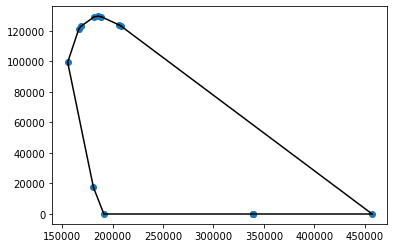

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

Hull = ConvexHull(solutions)

plt.figure()
plt.plot(solutions[:,0], solutions[:,1], 'o')

for simplex in hull.simplices:

    plt.plot(solutions[simplex, 0], solutions[simplex, 1], 'k-')

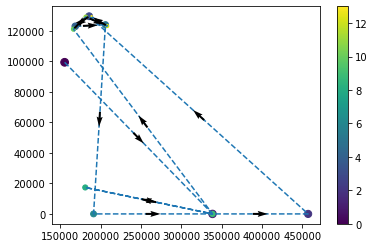

In [57]:
# -- Plot lines between points --
plt.plot(solutions[:,0], solutions[:,1], '--')

# -- Plot index at points --
#for i in range(solutions.shape[0]):
#    plt.text(solutions[i,0], solutions[i,1], str(i))

# -- Plot points with colors and scaling --
s = np.linspace(60, 5, len(solutions))
plt.scatter(solutions[:,0],solutions[:,1], c = np.arange(0, len(solutions)), s=s)
plt.colorbar()

# -- Plot arrows showing direction between points --
u = np.diff(solutions[:,0])
v = np.diff(solutions[:,1])
pos_x = solutions[:,0][:-1] + u/2
pos_y = solutions[:,1][:-1] + v/2
norm = np.sqrt(u**2+v**2) 
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")